In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import itertools
import random
#import warnings
#warnings.filterwarnings('ignore')

#### Import datasets

RPU

In [2]:
hill_params = {
    'e11x32STPhoRadA': [2.48594994e+00, 1.00000000e+02, 1.00000000e+01, 6.86746162e-01, -1.56322602e-02, -1.94982120e-03, 4.75926468e+00, 4.75926468e+00],
    'e15x32NpuSspS2': [2.54319918e+00, 2.09385185e+00, 5.73260805e+00, 2.69377365e+00, 5.73891081e-04, 5.74432669e-04, 6.43173741e-01, 6.43173741e-01],
    'e16x33NrdA2': [3.34334670e+00, 6.83803745e+01, 5.40225881e+00, 7.09474500e-01, 2.75680570e-03, -1.66152398e-02, 4.36266232e+00, 4.36266232e+00],
    'e20x32gp411': [1.19290340e+01, 6.97982032e-01, 1.50152029e+00, 2.18004944e+00, -1.25764336e-02, 4.95925643e-03, 2.79532785e+00, 2.79532785e+00],
    'e32x30SspGyrB': [3.70661740e+00, 4.60143893e+01, 3.52705652e+00, 8.06029979e-01, -4.48621250e-03, -9.24441845e-03, 3.78246257e+00, 3.78246257e+00],
    'e34x30MjaKlbA': [2.87401378e+00, 1.55884811e+01, 3.33677063e+00, 1.43699815e+00, 3.12055244e-03, -7.00962474e-03, 2.14444899e+00, 2.14444899e+00],
    'e38x32gp418': [2.57973028, 3.16457778, 5.00055352, 0.62980402, 0.01036013, -0.00963987, 1.36516976, 1.36516976],
    'e41x32NrdJ1': [3.18140100e+00, 1.62859939e+01, 4.28977915e+00, 1.03410985e+00, 7.50772506e-03, -5.70314216e-03, 2.11265973e+00, 2.11265973e+00],
    'e42x32STIMPDH1': [3.58977269, 10.29752001, 4.10950627, 0.82354612, -0.01668254, -0.01668254, 1.6664647, 1.6664647]
}

Point-estimate.

In [ ]:
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 3.56423426e+00, 1.50252702e-10, 3.55907011e+02, 4.95959256e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1.0 , 33.3864939, 26.68735596, 157.80098788, 157.51127152],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 12.31034403, 5.56520849, 389.61315225, 399.52903402],
    'e20x32gp411': [12.53828935, 1.0, 2.78451886, 1.49241488, 8.42038183, 19.770931, 316.74400613, 314.41729987],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 12.42641636, 10.01199595, 353.07383233, 353.36938984],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 8.91852601, 20.20877259, 289.53290172, 287.92030858],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 22.75331651, 18.846011, 222.80791219, 223.15092773],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1.0, 20.50936546, 14.68953094, 279.98024852, 280.45758993],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 19.08872036, 15.87715881, 232.88219568, 232.90886374]
}
gate_params = {
    "e11x32STPhoRadA": [1.46415109e-02, 6.63450682e+02, 1.58327452e-02, 0.02],
    "e15x32NpuSspS2": [0.03165863, 4.7853412,  0.02219695, 0.02],
    "e16x33NrdA2": [2.21403462e-02, 1.44320142e+02, 2.20095167e-02, 0.02],
    "e20x32gp411": [2.33100887e-02, 9.93028856e+01, 2.26403674e-02, 0.02],
    "e32x30SspGyrB": [ 0.03359541, 10.92812258,  0.02336038, 0.02],
    "e34x30MjaKlbA": [2.05466494e-02, 1.61293627e+02, 2.15819156e-02, 0.02],
    "e38x32gp418": [2.34074609e-02, 9.02122673e+01, 1.89467403e-02, 0.02],
    "e41x32NrdJ1": [2.31185209e-02, 1.45064667e+02, 2.17997477e-02, 0.02],
    "e42x32STIMPDH1": [0.03508648, 0.2788824,  0.02389252, 0.02]
}

Interval-estimate.

In [ ]:
hill_params = {
    'e11x32STPhoRadA': [7.645346632875684, 3.6278561616938205, 9.2171235388524, 1.1001985686622204, 14.8593116571963, 5.743762670085866, 458.5136836256326, 360.3202790463802],
    'e15x32NpuSspS2': [10.427864870911893, 9.059619137810259, 2.2173651514145054, 0.8959265079247906, 38.20872424607038, 26.812977822048122, 171.8535154764809, 149.69297721244843],
    'e16x33NrdA2': [9.991312723754868, 6.5897949388608605, 4.998239806913596, 1.2397846739565033, 7.416887642587476, 15.220098324908523, 196.10124234936688, 756.8276701181695],
    'e20x32gp411': [14.070212065863386, 0.7915636408282356, 2.0945754070850655, 1.0928383754262643, 10.826010849280056, 11.452710743807668, 511.61206006462345, 205.14895215235003],
    'e32x30SspGyrB': [10.653207289112212, 8.478594476251368, 3.11756946790781, 1.0683764045459927, 16.72019154901677, 9.778231993280107, 405.3316974141839, 289.8767336384693],
    'e34x30MjaKlbA': [1374.6349039619042, 12.144747077620854, 0.7451430715403362, 5.146751203285993, 11.715294696653377, 66.35185714414995, 1201.9421334190895, 805.9118807569571],
    'e38x32gp418': [7.395490239623599, 1.5509958154810697, 5.670357037879099, 1.3597918973710645, 19.06629063316735, 27.75559921258502, 163.83497173432002, 291.32238950469014],
    'e41x32NrdJ1': [9.79737497627455, 16.568623568277534, 3.407741906734099, 0.7844447687490096, 23.59776411698231, 13.14939309181156, 322.7098655707045, 264.1390343569163],
    'e42x32STIMPDH1': [10.336009368125339, 6.000475416768916, 4.477739982311845, 0.9757489564383387, 18.905781228897766, 21.953530170906987, 187.57210700503205, 278.66102832941397]
}
gate_params = {
    'e11x32STPhoRadA': [0.016119, 147.066713, 0.013177, 0.01],
    'e15x32NpuSspS2': [0.056225, 0.012144, 0.011197, 0.01],
    'e16x33NrdA2': [0.050964, 0.164080, 0.012668, 0.01],
    'e20x32gp411': [0.056090, 0.050514, 0.011701, 0.01],
    'e32x30SspGyrB': [0.059446, 0.046058, 0.013620, 0.01],
    'e34x30MjaKlbA': [0.035649, 16.158448, 0.015069, 0.01],
    'e38x32gp418': [0.051217, 0.121835, 0.011341, 0.01],
    'e41x32NrdJ1': [0.046434, 2.774168, 0.011096, 0.01],
    'e42x32STIMPDH1': [0.048353, 0.014531, 0.013498, 0.01]
}

In [50]:
fluos = pd.read_csv('datasets/induction_matrix_and/fluos.csv', index_col='time')
ods = pd.read_csv('datasets/induction_matrix_and/ods.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
controls = ['positive_control', 'negative_control']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]
cumas_rpu = [0.04, 2.09, 4.0, 5.7, 7.23, 8.26]
aras_rpu = [0.02, 0.67, 1.79, 6.09, 12.39, 12.57]

idx = 30
gfp = fluos[filter(lambda x: x.startswith('positive_control_4AE'), fluos.columns)].mean(axis=1)
neg = fluos[filter(lambda x: x.startswith('negative_control_4AE'), fluos.columns)].mean(axis=1)
fluos_rpu = np.abs(fluos.iloc[idx] - neg.iloc[idx]) / np.abs(gfp.iloc[idx] - neg.iloc[idx])

#### Static model

In [4]:
class Gate2:
    def __init__(self, name, hill_params):
        
        #metadata
        self.name = name
        self.num_params = len(hill_params)
        
        #parameters
        self.K1 = hill_params[0]
        self.K2 = hill_params[1]
        self.n1 = hill_params[2]
        self.n2 = hill_params[3]
        self.ymin1 = hill_params[4]
        self.ymin2 = hill_params[5]
        self.ymax1 = hill_params[6]
        self.ymax2 = hill_params[7]
        
        #output
        self.y = 0
        
        #connection
        self.connection = None
        
    def get_params(self):
        return [self.K1, self.K2, self.n1, self.n2, self.ymin1, self.ymin2, self.ymax1, self.ymax2]
    
    def get_init_states(self):
        return [self.y]
    
class Connection2:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        
        self.name = name
        self.index = index
        self.level = level #0: input, 1: intermediate, 2:output
        
        self.input1 = input1
        self.input2 = input2
        self.output = output
        
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit2:
    def __init__(self, arrangement, inducers):
        
        #inducers
        self.inducers = inducers
        
        #gate
        self.gates = []
        for arr in arrangement:
            self.gates.append(Gate2(arr, hill_params[arr]))
        
        self.connections = [
            Connection2('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4),
            Connection2('c2', self.inducers[2], self.inducers[3], None, 0, 1, 2, 3, 4),
            Connection2('c3', self.inducers[4], self.inducers[5], None, 0, 4, 0, 1, 6),
            Connection2('c4', self.inducers[6], self.inducers[7], None, 0, 3, 6, 7, 5),
            Connection2('c5', self.gates[0], self.gates[1], None, 1, 4, 0, 1, 6),
            Connection2('c6', self.gates[2], self.gates[3], None, 1, 5, 2, 3, 6),
            Connection2('c7', self.gates[4], self.gates[5], None, 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)

In [13]:
def hill_activation(x, K, n, ymin, ymax):
    return  ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

def signal_match(circuit):
    
    for i, g in enumerate(circuit.gates):
        
        #level 0 (input)
        if g.connection.level==0:
            g.y = hill_activation_and((circuit.inducers[i*2], circuit.inducers[(i*2)+1]), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
            #print(i, g.name, circuit.inducers[i*2], circuit.inducers[(i*2)+1], g.y)
        #level 1 (middle)
        else:
            input1 = g.connection.input1
            input2 = g.connection.input2
            g.y = hill_activation_and((input1.y, input2.y), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
            #print(i, g.name, input1.y, input2.y, g.y)
    return circuit.gates[-1].y

In [14]:
circuit2 = Circuit2([gates[g] for g in [0, 2, 3, 8, 5, 6, 7]], [cumas_rpu[4], aras_rpu[4]] * 4)
signal_match(circuit2)

0.0002377568211661754

#### Genetic Algorithm

In [66]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluos.index
    fitness = []
    
    for i, p in enumerate(pop):
        #circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        #model = gate_wrapper2(f_t, circuit)
        #gfp = pd.Series(model[33], index=f_t/60)
        
        #print(p, [gates[g] for g in pop])
        circuit1 = Circuit2([gates[g] for g in p], [cumas_rpu[5], aras_rpu[5]] * 4)
        #circuit2 = Circuit2([gates[g] for g in p], [cumas_rpu[3], aras_rpu[3]] * 4)
        #model = gate_wrapper(fluos.index, circuit, 2)
        #gfp = pd.Series(model[13], index=fluos.index/60)
        #fitness.append(gfp.max()-gfp.min())
        gfp1 = signal_match(circuit1)
        #gfp2 = signal_match(circuit2)
        fitness.append(gfp1)
        #fitness.append((gfp1 - gfp2))
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(gates), length=7)
result

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-66-da8cb6440063>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))
100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


array([[array([4, 2, 7, 5, 0, 3, 6]), 0.13154554178552305],
       [array([4, 2, 7, 5, 0, 3, 6]), 0.13154554178552305],
       [array([4, 2, 7, 5, 0, 3, 6]), 0.13154554178552305],
       [array([4, 2, 7, 5, 0, 3, 6]), 0.13154554178552305],
       [array([4, 2, 7, 5, 0, 3, 6]), 0.13154554178552305],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.09201482782946716],
       [array([2, 4, 7, 5, 0, 3, 6]), 0.

In [67]:
selected = [
    [4, 2, 7, 5, 0, 3, 6], [2, 4, 7, 5, 0, 3, 6], [4, 7, 2, 5, 0, 3, 6]
]

In [44]:
[cumas_rpu[5], aras_rpu[5], cumas_rpu[5], aras_rpu[5], cumas_rpu[5], aras_rpu[5], cumas_rpu[5], aras_rpu[5]]

[8.26, 12.57, 8.26, 12.57, 8.26, 12.57, 8.26, 12.57]

In [81]:
[5 if i=='1' else 3 for i in list(format(7, "08b"))]

[3, 3, 3, 3, 3, 5, 5, 5]

In [149]:
candidates = []
for r in selected:
    candidate = []
    for x in range(256):
        b = [5 if i=='1' else 1 for i in list(format(x, "08b"))]
        circuit2 = Circuit2([gates[g] for g in r], [cumas_rpu[b[7]], aras_rpu[b[6]], cumas_rpu[b[5]], aras_rpu[b[4]], cumas_rpu[b[3]], aras_rpu[b[2]], cumas_rpu[b[1]], aras_rpu[b[0]]])
        
        candidate.append(signal_match(circuit2))
    print([gates[g] for g in r])
    candidates.append(candidate)

['e32x30SspGyrB', 'e16x33NrdA2', 'e41x32NrdJ1', 'e34x30MjaKlbA', 'e11x32STPhoRadA', 'e20x32gp411', 'e38x32gp418']
['e16x33NrdA2', 'e32x30SspGyrB', 'e41x32NrdJ1', 'e34x30MjaKlbA', 'e11x32STPhoRadA', 'e20x32gp411', 'e38x32gp418']
['e32x30SspGyrB', 'e41x32NrdJ1', 'e16x33NrdA2', 'e34x30MjaKlbA', 'e11x32STPhoRadA', 'e20x32gp411', 'e38x32gp418']


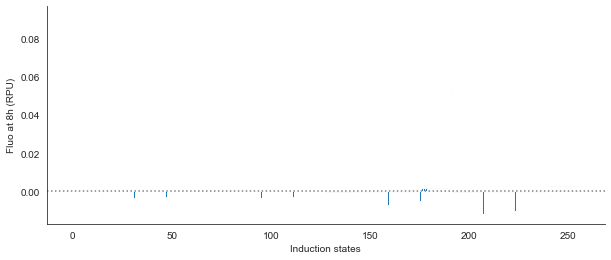

In [146]:
plt.figure(figsize=[10, 4])
plt.bar(np.arange(256), candidates[1])
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('Fluo at 8h (RPU)')
plt.xlabel('Induction states')
sns.despine()

In [148]:
candidates

[[(-0.00010609720392716939+1.4454107597020485e-05j),
  (-0.00010609720392716939+1.4454107597020485e-05j),
  (-0.00010609720392716939+1.4454107597020485e-05j),
  (-0.00010609853523410271+1.4454288967056137e-05j),
  (-0.00010609720392716374+1.4454107597019726e-05j),
  (-0.00010609720392716374+1.4454107597019726e-05j),
  (-0.00010609720392716374+1.4454107597019726e-05j),
  (-0.00011864425905355843+1.616345033282969e-05j),
  (-0.00010609720392716877+1.4454107597020402e-05j),
  (-0.00010609720392716877+1.4454107597020402e-05j),
  (-0.00010609720392716877+1.4454107597020402e-05j),
  (-0.00010746218479790408+1.4640065187260255e-05j),
  (-0.00010609720392395098+1.4454107596587724e-05j),
  (-0.00010609720392395103+1.4454107596587731e-05j),
  (-0.00010609720392395109+1.4454107596587738e-05j),
  (-0.0048214256248728694+0.0006568448759571704j),
  (-0.00010491641088662142+1.1706997036201334e-05j),
  (-0.00010491641088662142+1.1706997036201334e-05j),
  (-0.00010491641088662142+1.1706997036201334e-05

In [147]:
[gates[g] for g in candidates[0]]

TypeError: list indices must be integers or slices, not complex

#### Layering the Gates

In [ ]:
class Gate:
    def __init__(self, name, gate_params, hill_params, num_states, num_params):
        
        #metadata
        self.name = name
        self.num_states = num_states
        self.num_params = num_params
        
        #parameters
        self.r = gate_params[0]
        self.y0 = gate_params[1]
        self.synGFP = gate_params[2]
        self.degGFP = gate_params[3]
        self.K1 = hill_params[0]
        self.K2 = hill_params[1]
        self.n1 = hill_params[2]
        self.n2 = hill_params[3]
        self.ymin1 = hill_params[4]
        self.ymin2 = hill_params[5]
        self.ymax1 = hill_params[6]
        self.ymax2 = hill_params[7]
        
        #initial states
        self.y = self.y0
        self.GFP = 0
        
        #derivative states
        self.dy = 0
        self.dGFP = 0
        
        #connection
        self.connection = None
        
    def get_params(self):
        return [self.r, self.y0, self.syn_GFP, self.deg_GFP]
    
    def get_init_states(self):
        return [self.y, self.GFP]
    
class Connection:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        
        self.name = name
        self.index = index
        self.level = level #0: input, 1: intermediate, 2:output
        
        self.input1 = input1
        self.input2 = input2
        self.output = output
        
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit:
    def __init__(self, arrangement, inducers):
        
        #inducers
        self.inducers = inducers
        
        #gate
        self.gates = []
        for arr in arrangement:
            self.gates.append(Gate(arr, gate_params[arr], hill_params[arr], 2, 11))
        
        self.connections = [
            Connection('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4),
            Connection('c2', self.inducers[2], self.inducers[3], None, 0, 1, 2, 3, 4),
            Connection('c3', self.inducers[4], self.inducers[5], None, 0, 4, 0, 1, 6),
            Connection('c4', self.inducers[6], self.inducers[7], None, 0, 3, 6, 7, 5),
            Connection('c5', self.gates[0], self.gates[1], None, 1, 4, 0, 1, 6),
            Connection('c6', self.gates[2], self.gates[3], None, 1, 5, 2, 3, 6),
            Connection('c7', self.gates[4], self.gates[5], None, 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)

In [ ]:
def hill_activation(x, K, n, ymin, ymax):
    return  ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

def gate_wrapper(t, circuit, num_states):
    
    y0 = np.array([g.get_init_states() for g in circuit.gates]).ravel()
    
    def gate_model(y, t):
        
        yi = np.reshape(y, (-1, num_states))
        yn = []

        for i, g in enumerate(circuit.gates):
            
            g.y, g.GFP = yi[i]
            
            #level 0 (input)
            if g.connection.level==0:
                
                ymax = hill_activation_and((circuit.inducers[i*2], circuit.inducers[(i*2)+1]), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
                #print(i, ymax)
                g.dy = g.r * (1 - (g.y/ymax)) * g.y
                yn.append([g.dy, g.dGFP])
                
            #level 1 (middle)
            elif g.connection.level==1:

                input1 = g.connection.input1
                input2 = g.connection.input2
                ymax = hill_activation_and((input1.y, input2.y), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
                g.dy = g.r * (1 - (g.y/ymax)) * g.y
                #g.dGFP = g.synGFP * g.y - g.degGFP * g.GFP
                yn.append([g.dy, g.dGFP])
                
            #level 2 (output)
            elif g.connection.level==2:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                ymax = hill_activation_and((input1.y, input2.y), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
                g.dy = g.r * (1 - (g.y/ymax)) * g.y
                g.dGFP = g.synGFP * g.y - g.degGFP * g.GFP
                yn.append([g.dy, g.dGFP])
        
        return np.array(yn).ravel()
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

In [ ]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluos.index
    fitness = []
    
    for i, p in enumerate(pop):
        
        #circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        #model = gate_wrapper2(f_t, circuit)
        #gfp = pd.Series(model[33], index=f_t/60)

        circuit = Circuit(gates[:7], [cumas_rpu[5], aras_rpu[5]] * 4)
        model = gate_wrapper(fluos.index, circuit, 2)
        gfp = pd.Series(model[13], index=fluos.index/60)

        fitness.append(gfp.max()-gfp.min())
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(gates), length=7)
result

In [ ]:
#selected_gates = [4, 0, 3, 5, 2, 6, 1]
[gates[g] for g in result[0][0]]

In [ ]:
#point
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit = Circuit([gates[g] for g in selected_gates], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

In [ ]:
#interval
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit2 = Circuit([gates[g] for g in result[0][0]], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit2, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

In [ ]:
circuit1 = Circuit([gates[g] for g in selected_gates], [cumas[5], aras[5]] * 4)
model = gate_wrapper(fluos.index, circuit1, 2)
for i, m in enumerate(model):
    if i%2==0:
        pd.Series(m, index=fluos.index/60, name=i).plot()
plt.legend()
sns.despine()

In [ ]:
circuit2 = Circuit2([gates[g] for g in result[0][0]], [cumas[5], aras[5]] * 4)
signal_match(circuit2)

In [ ]:
circuit2 = Circuit2([gates[g] for g in result[0][0]], [cumas[1], aras[1]] * 4)
signal_match(circuit2)

In [ ]:
cumas_rpu, aras_rpu

In [ ]:
circuit2 = Circuit2([gates[g] for g in [0, 2, 3, 8, 5, 6, 7]], [cumas_rpu[4], aras_rpu[4]] * 4)
signal_match(circuit2)

In [ ]:
circuit2 = Circuit2([gates[g] for g in [1, 2, 3, 4, 5, 6, 7]], [cumas_rpu[5], aras_rpu[5]] * 4)
signal_match(circuit2)

In [ ]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluos.index
    fitness = []
    
    for i, p in enumerate(pop):
        #circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        #model = gate_wrapper2(f_t, circuit)
        #gfp = pd.Series(model[33], index=f_t/60)
        
        circuit = Circuit(gates[:7], [cumas[5], aras[5]] * 4)
        #model = gate_wrapper(fluos.index, circuit, 2)
        #gfp = pd.Series(model[13], index=fluos.index/60)
        #fitness.append(gfp.max()-gfp.min())
        gfp = signal_match(circuit)
        fitness.append(gfp)
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(gates), length=7)
result

In [ ]:
#hill function
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit2 = Circuit([gates[g] for g in [1, 2, 3, 4, 5, 6, 7]], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit2, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

### Exhaustive Search

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
all_arr = [list(a) for a in list(itertools.permutations(np.arange(len(gate_params_selected)), 7))]
len(all_arr)

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
#arr = np.arange(len(gate_params_selected))
#np.random.shuffle(arr)
#print(arr)
f_t = fluo_selected.index

results = []
for i, arr in enumerate(tqdm(all_arr)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    dyn = gfp.max() - gfp.min()
    results.append((dyn, arr))

In [ ]:
best_results = sorted(results, reverse=True)[:10]
print('Best result', best_results[0][0])
for i, res in enumerate(tqdm(best_results)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, res[1])
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    plt.plot(gfp, label= res[1])
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

In [ ]:
final_asg = fluo_selected[[fluo_selected.columns[j] for j in ga_arrangement]]
num_col = 7
num_row = 1
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        ax.plot(final_asg.index / 60, final_asg.iloc[:, i])
        ax.set_title(final_asg.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def geneticAlgorithmPlot(pop_copy, popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = [i for i in pop_copy]
    progress = []
    progress.append(rankIndiv(pop)[0][1])
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
        progress.append(rankIndiv(pop)[0][1])
    return progress
    
progress = geneticAlgorithmPlot(pop_copy, popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(selected), length=7)
plt.figure(figsize=[6, 4])
plt.plot(progress[:20])
plt.ylabel('Dynamic Range')
plt.xlabel('Generation')
sns.despine()
plt.show()

In [ ]:
circuit = Circuit(gates[:7], [cumas[2], aras[2]] * 4)
model = gate_wrapper(fluos.index, circuit, 2)
gfp = pd.Series(model[13], index=fluos.index/60)